# nflows package

In [1]:
# Classes implemented in the previous task

from nflows.transforms import AffineCouplingTransform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal

In [2]:
# Let us try more expressive transforms!

from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform   # MAF (from the lecture)
from nflows.transforms import PiecewiseRationalQuadraticCouplingTransform  # neural spline flows https://arxiv.org/abs/1906.04032
from nflows.transforms import BatchNorm  # introduced along with the Real-NVP

# Define the flow

In nflows, the scale and shift neural networks are merged into one - this enables a flexible API where any invertible parameterized transform $g_{\theta}(x)$ is defined by a number or respective parameters $\theta$. In the case of real-nvp, there are two parameters: $g_{s, t}(x) = x \cdot \exp(s) + t$.

In [5]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

from nflows.nn.nets import ResidualNet

def get_nn_for_transform_parameters(context_features: int,  hidden_features: int = 64, num_blocks: int = 2, activation=F.gelu, use_batch_norm: bool = True):
    def func(in_dim: int, out_dim: int):
        return ResidualNet(
            in_dim, out_dim, hidden_features=hidden_features,
            context_features=context_features, num_blocks=num_blocks, activation=activation, use_batch_norm=use_batch_norm
        )
    return func

In [6]:
num_transforms = 10
D = 784
hid_dim = 64
context_features = 2  # number of digits
hidden_features = 64
num_blocks = 3


base_dist = StandardNormal(shape=[D])

transforms = []

for i in range(num_transforms):
    mask = torch.arange(D) % 2 == i % 2

    # use random permutation
    mask = mask[torch.randperm(D)]

    transforms.append(
        PiecewiseRationalQuadraticCouplingTransform(mask, get_nn_for_transform_parameters(
            context_features=context_features,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        ), tail_bound=5, tails='linear',
        )   
    )

    transforms.append(BatchNorm(features=D))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

print('Number of parameters:', sum(p.numel() for p in flow.parameters()))


Number of parameters: 7920720


# MNIST dataset

### Define dataset

In [7]:
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np


# Define the MNIST dataset with preprocessing
class NoisyMNIST(datasets.MNIST):
    def __init__(self, *args, noise_std=0.1, subset_digits=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_std = noise_std
        self.subset_digits = subset_digits if subset_digits is not None else list(range(10))
        self.num_classes = len(self.subset_digits)
        self.mapping = {digit: idx for idx, digit in enumerate(self.subset_digits)}
    
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        noise = torch.randn_like(img) * self.noise_std
        img = img + noise
        img = (img - img.mean()) / img.std()  # Standardize the image
        mapped_target = torch.tensor(self.mapping.get(target, -1))

        if mapped_target.item() < 0:
            return img, target, None

        one_hot_target = F.one_hot(mapped_target, self.num_classes).float()
        return img, target, one_hot_target

### Pick your two favorite digits

In [8]:
# Define the subset of digits to use
subset_digits = [0, 7]  # Modify this list to select the desired digits


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = NoisyMNIST(root='./data', train=True, download=True, transform=transform, subset_digits=subset_digits)
test_dataset = NoisyMNIST(root='./data', train=False, download=True, transform=transform, subset_digits=subset_digits)

In [9]:
# Filter the dataset to include only the desired digits
def filter_digits(dataset, digits):
    indices = [i for i, (_, target, _) in enumerate(dataset) if target in digits]
    return Subset(dataset, indices)


train_dataset = filter_digits(train_dataset, subset_digits)
test_dataset = filter_digits(test_dataset, subset_digits)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train

In [10]:
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

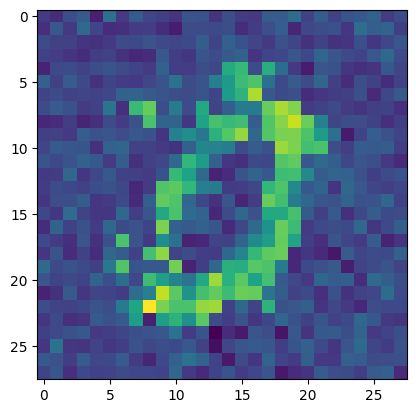

  0%|          | 0/191 [00:00<?, ?it/s]

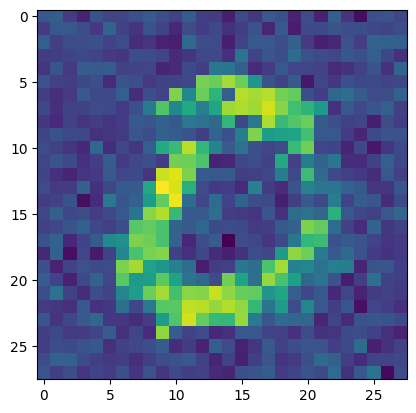

  0%|          | 0/191 [00:00<?, ?it/s]

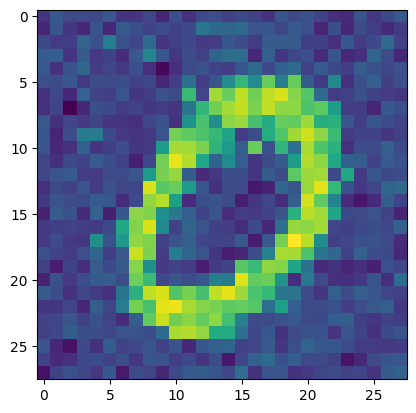

  0%|          | 0/191 [00:00<?, ?it/s]

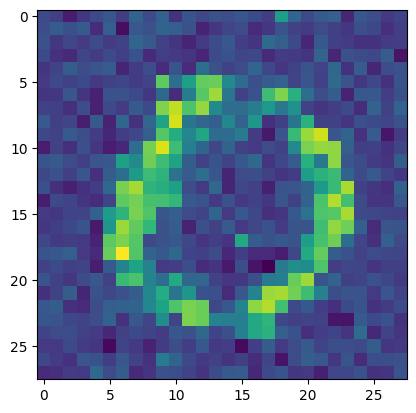

  0%|          | 0/191 [00:00<?, ?it/s]

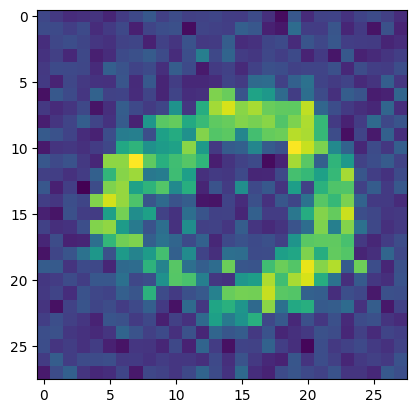

  0%|          | 0/191 [00:00<?, ?it/s]

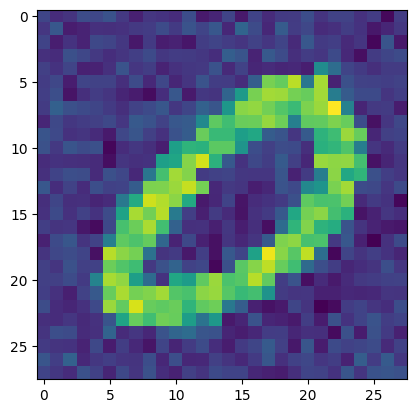

  0%|          | 0/191 [00:00<?, ?it/s]

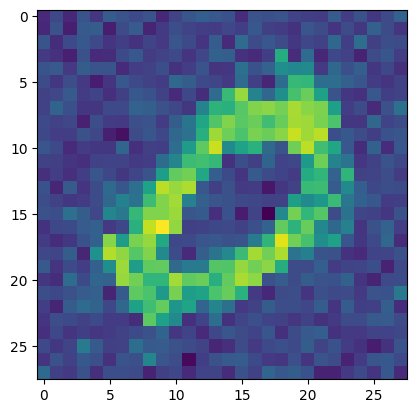

  0%|          | 0/191 [00:00<?, ?it/s]

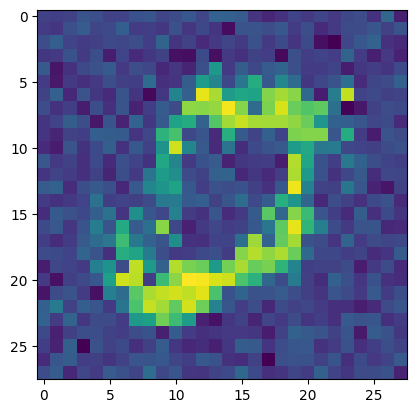

  0%|          | 0/191 [00:00<?, ?it/s]

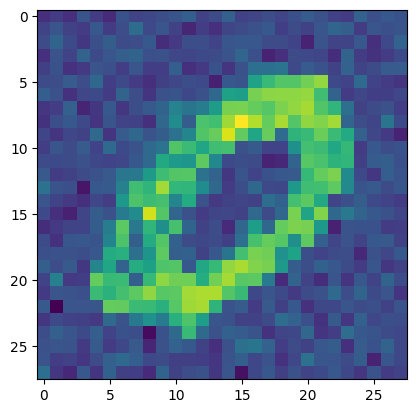

  0%|          | 0/191 [00:00<?, ?it/s]

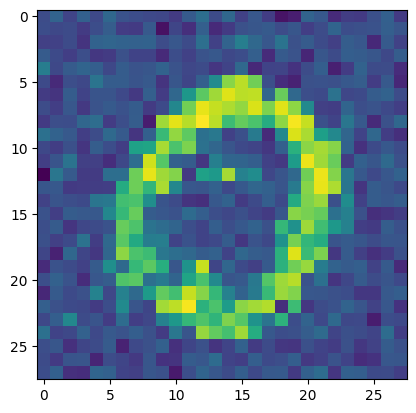

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

flow.to(device)

optim = AdamW(flow.parameters(), lr=1e-3)

# Training loop
num_epochs = 10

pbar = trange(num_epochs)

losses = []

for epoch in pbar:
    flow.train()
    total_loss = 0

    epoch_pbar = tqdm(train_loader)

    for i, batch in enumerate(epoch_pbar):
        optim.zero_grad()
        imgs, _, context = batch
        imgs = imgs.view(imgs.size(0), -1)  # Flatten the images
        loss = - flow.log_prob(imgs.to(device), context=context.to(device)).mean() 
        loss.backward()
        optim.step()
        total_loss += loss.item() 

        epoch_pbar.set_description(f'current loss: {total_loss/  (i + 1):.2e}')
    
    avg_loss = total_loss / len(train_loader)
    pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.2e}')

    losses.append(avg_loss)

    flow.eval();

    with torch.no_grad():
        sample = flow.sample(1, context=torch.tensor([[1, 0]]).float().to(device))
        img = sample.view(28, 28).cpu().numpy()
        plt.imshow(img)
        plt.show()

# Tests

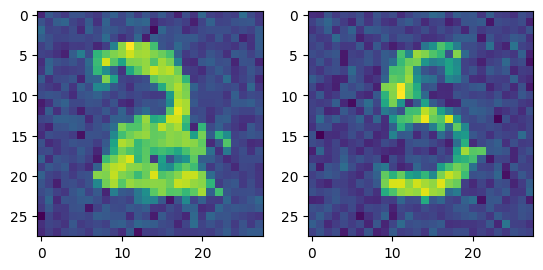

In [105]:
flow.eval();

with torch.no_grad():
    img1 = flow.sample(1, context=torch.tensor([[1, 0]]).float().cuda()).view(28, 28).cpu().numpy()
    img2 = flow.sample(1, context=torch.tensor([[0, 1]]).float().cuda()).view(28, 28).cpu().numpy()

fig, axs = plt.subplots(ncols=2, )
axs[0].imshow(img1)
axs[1].imshow(img2)
